In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType
import os
import pyspark.sql.functions as sql
import pandas as pd

In [2]:
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
spark = SparkSession\
  .builder \
  .appName("word_counter") \
  .getOrCreate()

In [4]:
filenames = os.listdir('data')
filenames

['data_1.csv',
 'data_10.csv',
 'data_2.csv',
 'data_3.csv',
 'data_4.csv',
 'data_5.csv',
 'data_6.csv',
 'data_7.csv',
 'data_8.csv',
 'data_9.csv']

In [5]:
data = []
amount_of_words_all_files = 0
countTokens = sql.udf(lambda w: len(w), IntegerType())

target_columns = {'data_1.csv': 'text', 'data_2.csv': 'text', 'data_3.csv': 'Team','data_4.csv': 'event_team','data_5.csv': 'Driver',
                  'data_6.csv': 'at','data_7.csv': 'review','data_8.csv': 'Review_Text','data_9.csv': 'Message', 'data_10.csv': 'positives'}

In [6]:
for i in filenames:
    df = spark.read.format('csv').options(header='true', inferSchema='true').load(f'data/{i}')
    df = df.dropna()
    
    #Tokenizing text, while removing anything except words
    regextokenizer = RegexTokenizer(inputCol=target_columns[i], outputCol='words', gaps=False, pattern='\\b[a-zA-Z]+\\b')
    tokenized = regextokenizer.transform(df)
    
    #Removing stop words from the tokens
    remover = StopWordsRemover(inputCol='words', outputCol='cleaned')
    removed = remover.transform(tokenized)
    
    amount_of_words = [row['cleaned'] for row in removed.collect()]
    full_amount = 0
    for list in amount_of_words:
        full_amount+= len(list)
    
    print(f'In file {i} in the column {target_columns[i]} the total amount of words is {full_amount}\n')
    print(f'The top 10 words by amount are\n')
    removed = removed.withColumn('word', sql.explode(sql.col('cleaned'))).groupBy('word').count().sort('count', ascending=False)
    removed.show(10)

    amount_of_words_all_files +=full_amount

In file data_1.csv in the column text the total amount of words is 483001

The top 10 words by amount are

+------+-----+
|  word|count|
+------+-----+
|  said| 7255|
|    mr| 3005|
|  year| 2309|
|  also| 2156|
|people| 2045|
|   new| 1978|
|    us| 1972|
|   one| 1892|
|  last| 1394|
| first| 1355|
+------+-----+
only showing top 10 rows

In file data_10.csv in the column positives the total amount of words is 155886

The top 10 words by amount are

+-----------+-----+
|       word|count|
+-----------+-----+
|       work| 5094|
|      great| 4321|
|       good| 3499|
|     people| 3009|
|   benefits| 2767|
|    company| 2202|
|        pay| 1527|
|environment| 1235|
|        get| 1148|
|    working| 1128|
+-----------+-----+
only showing top 10 rows

In file data_2.csv in the column text the total amount of words is 47

The top 10 words by amount are

+----------+-----+
|      word|count|
+----------+-----+
|    column|    1|
|     dozen|    1|
|    happen|    1|
|    flower|    1|
| 

In [7]:
print(f'Amount of words in all files is {amount_of_words_all_files}')

Amount of words in all files is 4340746


# Analysing the data_8.csv
<p>This file contains information about the DinsneyLand reviews from TripAdvisor</p>
Link - https://www.kaggle.com/arushchillar/disneyland-reviews

In [8]:
df = pd.read_csv(f'data/data_8.csv')
full_string = " ".join(df['Review_Text'])

## Tokenising and normalising different forms of words - lowering and lemmatising

In [9]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

tokeniser = RegexpTokenizer("[A-Za-z]+")
tokens = tokeniser.tokenize(full_string)
print(f"First 10 tokens {tokens[:10]}")
print(f"Number of tokens {len(tokens)}")
uniq_num = len(set(tokens))
print(f"Number of unique tokens {uniq_num}")

tokens_norm = [lemmatiser.lemmatize(t.lower(), "v") for t in tokens]
print(f"Number of unique tokens {len(set(tokens_norm))}")
print(f"Share of left tokens from original {(len(set(tokens_norm))/uniq_num):.2f}")

First 10 tokens ['If', 'you', 've', 'ever', 'been', 'to', 'Disneyland', 'anywhere', 'you', 'll']
Number of tokens 5551064
Number of unique tokens 50012
Number of unique tokens 33063
Share of left tokens from original 0.66


### The average number of characters per token

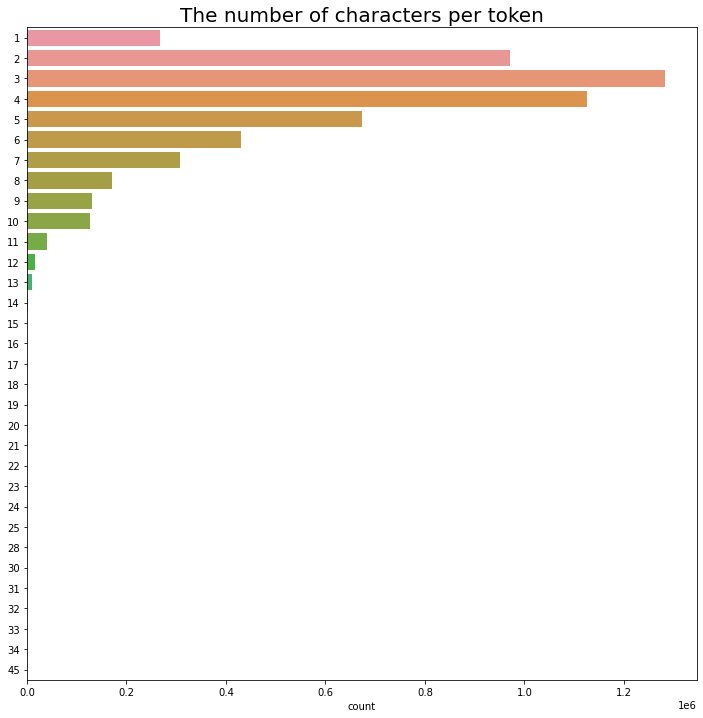

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

token_length = [len(t) for t in tokens]

plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("The number of characters per token", size=20)
plt.show()

### The reviews word cloud

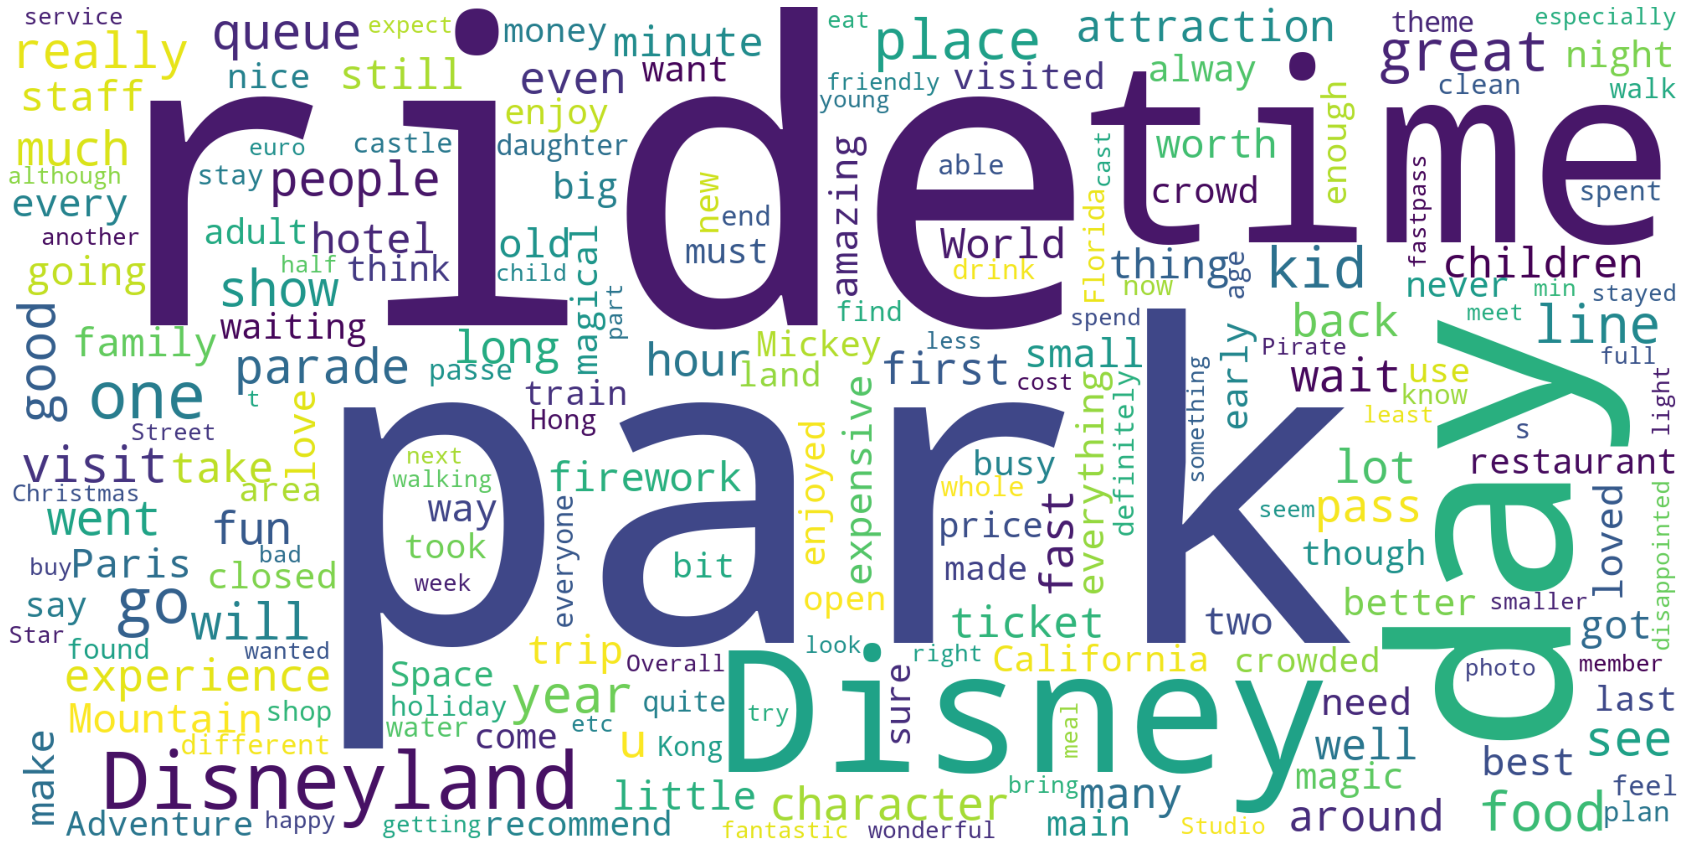

In [11]:
from wordcloud import WordCloud, STOPWORDS

data = df['Review_Text'].to_json()
wordcloud = WordCloud(width = 2000, height = 1000, random_state=7, background_color='white', collocations=False, stopwords = STOPWORDS).generate(data)

plt.figure(figsize=(30, 20))
plt.imshow(wordcloud) 
plt.axis("off")

plt.show()